![](../assets/images/banner.png)

# Part 3: Modeling

## Summary

In this section, with the cleaned 'train_weather_weekly' dataset, we can now proceed to modeling. We will be using the following models. They are

* Logistic Regression
* Naive Bayes
* Random Forest
* Extra Trees
* AdaBoost
* GradientBoost

The 'train_weather_weekly' dataset is split into 80% train and validation set, 20% test set. GridSearch CV is applied across 5 folds on the data, to find the best hyperparameters for all the models. We will also evaluate the results of each of the model to help us gain more perpective on the West Nile Virus.

Do note that the data is heavily imbalanced (the baseline score is ~94.12%). Thus, after determining the best hyperparameters for each of the model, we will re-fit the model using over-sampled data, which is obtained using SMOTE (Synthetic Minority Over-sampling Technique).

To determine the final model to use to perform the predictions in the test dataset, we will assess the models using the following metrics. We will primarily look at:
* AUC Score
* Training Score
* Test Score
* Recall
* Precision


Why do we want to look at AUC score then? As earlier stated, our dataset is heavily imbalanced and the baseline accuracy is ~94%. This means that, if our model predicts that every point is Wnv NOT present, our accuracy is 94%. Thus, accuracy is not the best metric for validation in this situation. AUC, on the other hand, utilizes probabilites of class prediction and provides an aggregate measure of performance across all possible classification thresholds. This allows us to be able to more precisely evaluate and compare the models.

Our final selected model is the GradientBoostingClassifier(max_depth=2, min_samples_leaf=2). After running this model on the test dataset, we achieved a Kaggle Score of 0.49709.


## Outline

* [Section 1: Preprocessing](#sec_1)
* [Section 2: Hyperparameter Tuning & Modeling](#sec_2)
    * 2.1 Logsitic Regression
    * 2.2 Naives Bayes
    * 2.3 Random Forest
    * 2.4 EctraTrees
    * 2.5 AdaBoost
    * 2.6 GradientBoost
* [Section 3: Final Model Selection](#sec_3)
* [Section 4: Cleaning & Preprocessing for Test dataset](#sec_4)
* [Section 5: Kaggle Submission](#sec_5)
* [Section 6: Future Recommendations](#sec_6)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_recall_fscore_support,  roc_auc_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc

## <a name="sec_1"></a>Section 1: Preprocessing

We will be dropping the features 'Year-Week', 'Year', 'Month', 'Week', 'Species', 'NumMosquitos'.

For 'NumMosquitos', we will drop this because this feature is not present in the test dataset. We ran a few linear regression models to predict the NumMosquitos in the test dataset. However, we did not get successful enough results to improve our final model in the prediction of the presence of the Wnv Virus.

For 'Species', we will drop this column as the column 'Is WnV Present' is already indicative of the Species as only certain type of species were found to contain the Wnv Virus.

For 'Year-Week', 'Year', 'Month' and 'Week', we iniitally thought these to be useful as there are should be more mosquitos and hence a greater probability of the presence of the Wnv Virus in certain times of the year. However, these are already covered and touched upon by the other features which describe the weather.

In [2]:
df = pd.read_csv('../assets/cleaned_datasets/train_weather_weekly.csv')

In [3]:
# Setting the variables
X = df[[col for col in df.columns if col not in ['WnvPresent', 'Year-Week', 'Year', 'Month', 'Week','Species','NumMosquitos']]]
y = df['WnvPresent']

## <a name="sec_2"></a>Section 2: Hyperparameter Tuning & Modeling

In this section, we will run hyperparameter tuning for the models chosen. Then, since the data is heavily imbalanced, we will re-fit the model using the over-sampled data, which is obtained using SMOTE and obtain the train and test scores. 



In [4]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2, stratify=y)

### Baseline Prediction

In [5]:
# Look at the proportions of each outcome
y_train.value_counts(normalize=True)

0    0.941245
1    0.058755
Name: WnvPresent, dtype: float64

The data is heavily imbalanced. We will be ~94% accurate if we were to predict all to be the negative class (WNV not present). As such, we will be optimizing our models using AUC score instead of accuracy. We will also deploy SMOTE (Synthetic Minority Over-sampling Technique) to help us with over-sampling.

In [6]:
# Scaling
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [7]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

In [8]:
# Check proportions after SMOTE
ysm_train.value_counts()

0    5687
1    5687
Name: WnvPresent, dtype: int64

When we apply GridSearchCV to perform hyperparameter tuning, we will need to utilize an `imblearn.Pipeline` object to handle the imbalanced dataset correctly. The over-sampled data will only be used when evaluating the train and test scores. 

### 2.1 Logistic Regression

In [9]:
%%time
# This framework will be the one we use for our modelling

print(f'Fitting Logistic Regression')      # Prints out what model that we are using 

# Set up pipeline
lr_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('lr', LogisticRegression(solver='newton-cg'))
    ])

# Hyperparameters
lr_params = {
    'lr__C': np.linspace(0.1,1,5),
}

# Instantiate 5-fold GridSearchCV.
gs_lr = GridSearchCV(lr_pipe, param_grid = lr_params, cv=5,
                     scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit
gs_lr.fit(Xs_train, y_train)


# See results
print(f'The best parameters are {gs_lr.best_estimator_}.')

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('lr', LogisticRegression(solver='newton-cg'))]).
CPU times: user 1.3 s, sys: 530 ms, total: 1.83 s
Wall time: 3.58 s


Using these best hyperparameters, we will re-fit the model based on the over-sampled data and obtain the scoring metrics

In [10]:
# Re-fit model on over-sampled data
lr = LogisticRegression(solver='newton-cg')
lr.fit(Xsm_train, ysm_train)

LogisticRegression(solver='newton-cg')

In [11]:
# Create list to store all the scores and corresponding model names
model_name = []
model_scores = []
model_var = []
model_test_scores = []


model_name.append('Logistic Regression')
model_scores.append(lr.score(Xsm_train, ysm_train))
model_var.append(lr)
model_test_scores.append(lr.score(Xs_test,y_test))

### Evaluating Logistic Regression Results

Let us find the factors/coeffciencts that had the most influence and try to make sense of it

In [12]:
importance = lr.coef_
features = X_train.columns
importance = importance.reshape(lr.coef_.shape[1],1)
imp_lr = pd.DataFrame(importance,
                       index=features,
                       columns=['weights']).sort_values(by='weights', ascending=False)
imp_lr

,weights
Tavg_1,2.742006
Tmax_1,2.437016
RH_1,1.994128
AvgSpeed_2,1.765830
Tmin_1,1.482819
Is Wnv Mosquitoes Types,1.383828
WetBulb_1,1.269261
Tmax_2,1.265871
DewPoint_1,1.011346
PrecipTotal_2,0.981208


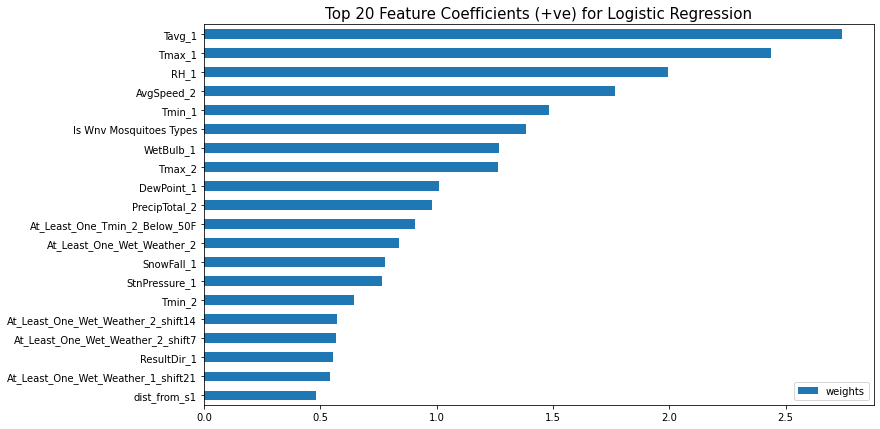

In [13]:
# Plotting top 20 +ve features in bar chart
imp_lr['weights'].head(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (+ve) for Logistic Regression', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

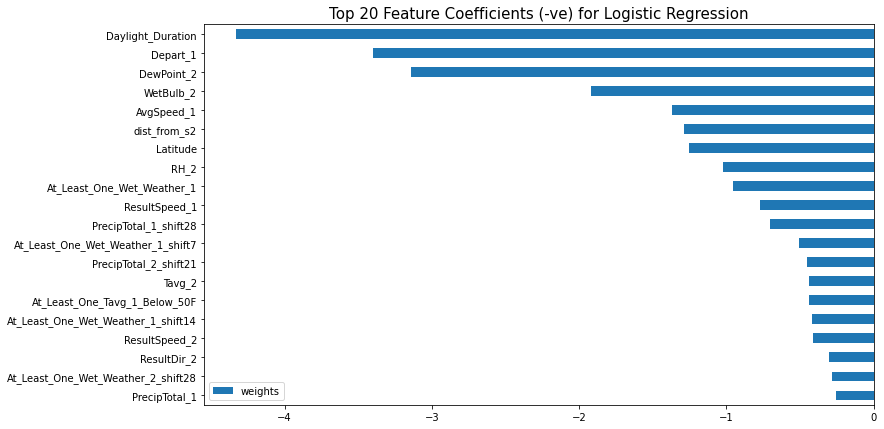

In [14]:
# Plotting top 20 -ve features in bar chart
imp_lr['weights'].tail(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (-ve) for Logistic Regression', fontsize=15)
plt.legend(loc=3);

The plots above display the most important features that contribute to the presence of the Wnv Virus.
According to this [article](https://blog.mosquito.buzz/how-weather-affects-mosquito-activity), weather is a major motivator for what mosquitoes do, and when. This would explain why the top predictors all involve elements that are related to present weather condition.

Moreover, the Daylight duration has a high negative coefficient which suggests that the longer the daylight duration, the lower the chance of Wnv being present. This corroborates with this [article](https://blog.mosquito.buzz/how-weather-affects-mosquito-activity), where it states that warm evening temperatures allow mosquitoes to thrive, since prolonged sun exposure can actually dehydrate them.


In [15]:
# Get predictions
preds = lr.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/joeltan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


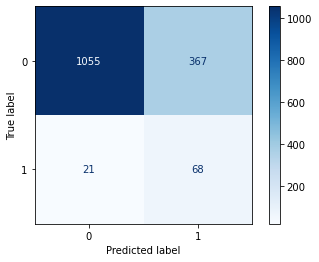

In [16]:
# View confusion matrix

plot_confusion_matrix(lr, Xs_test, y_test, cmap='Blues', values_format='d');

Using Logistic Regression, out of 1511 data points in our test dataset, we classified 1123 (74.32%) correctly. 

### 2.2 Naive Bayes

In [17]:
%%time

print(f'Fitting Naive Bayes')      

# Set up pipeline
nb_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('nb', BernoulliNB())
    ])

# Hyperparameters
nb_params = {
    'nb__alpha': [0.9, 1, 1.1]
}

# Instantiate 5-fold GridSearchCV.
gs_nb = GridSearchCV(nb_pipe, param_grid = nb_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit
gs_nb.fit(Xs_train, y_train)

# See results
print(f'The best parameters are {gs_nb.best_estimator_}.')

Fitting Naive Bayes
Fitting 5 folds for each of 3 candidates, totalling 15 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('nb', BernoulliNB(alpha=0.9))]).
CPU times: user 407 ms, sys: 193 ms, total: 600 ms
Wall time: 263 ms


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [18]:
nb = BernoulliNB(alpha=0.9)
nb.fit(Xsm_train, ysm_train)

BernoulliNB(alpha=0.9)

In [19]:
# Append to the lists
model_name.append('Naive Bayes')
model_scores.append(nb.score(Xsm_train, ysm_train))
model_var.append(nb)
model_test_scores.append(nb.score(Xs_test,y_test)) 

### Evaluating Naive Bayes Results

In [20]:
nb.feature_count_

array([[5448., 2897., 2881., 3332., 2935., 2885., 3048., 3300., 3227.,
         203., 1971., 2973., 3187., 2906., 2517., 3089., 3305., 3169.,
        3215., 3121., 2184., 2973., 3429., 3075., 2748., 3290., 2755.,
        2442., 1726., 2146., 1755., 2502., 1771., 2351., 1670., 2328.,
        5321., 5304., 5138., 5105., 5085., 4900., 5195., 5039., 5330.,
        5064.,   63., 1098.,    0.,  764., 2912., 2845.],
       [5687., 3270., 2263., 3854., 4170., 3823., 3410., 4285., 4350.,
          22., 2584., 3750., 2272., 3355., 1757., 3526., 4171., 3942.,
        4082., 4059., 2477., 3749., 2732., 3615., 2109., 1633., 3360.,
        2681., 2609., 2642., 2691., 2661., 2361., 2558., 1760., 2195.,
        5268., 4841., 5152., 4942., 5427., 4992., 5619., 5338., 5643.,
        5355.,    0.,  721.,    0.,  473., 3269., 2323.]])

In [21]:
# number of times each feature appear in Wnv NOT present
class0_count = nb.feature_count_[0, :]
class0_count

array([5448., 2897., 2881., 3332., 2935., 2885., 3048., 3300., 3227.,
        203., 1971., 2973., 3187., 2906., 2517., 3089., 3305., 3169.,
       3215., 3121., 2184., 2973., 3429., 3075., 2748., 3290., 2755.,
       2442., 1726., 2146., 1755., 2502., 1771., 2351., 1670., 2328.,
       5321., 5304., 5138., 5105., 5085., 4900., 5195., 5039., 5330.,
       5064.,   63., 1098.,    0.,  764., 2912., 2845.])

In [22]:
# number of times each feature appear in Wnv present
class1_count = nb.feature_count_[1, :]
class1_count

array([5687., 3270., 2263., 3854., 4170., 3823., 3410., 4285., 4350.,
         22., 2584., 3750., 2272., 3355., 1757., 3526., 4171., 3942.,
       4082., 4059., 2477., 3749., 2732., 3615., 2109., 1633., 3360.,
       2681., 2609., 2642., 2691., 2661., 2361., 2558., 1760., 2195.,
       5268., 4841., 5152., 4942., 5427., 4992., 5619., 5338., 5643.,
       5355.,    0.,  721.,    0.,  473., 3269., 2323.])

In [23]:
# create a DataFrame of features with their separate class counts
features = pd.DataFrame({'feature':X_train.columns, 'Wnv NOT present':class0_count, 'Wnv present':class1_count}).set_index('feature')
features.head()


,Wnv NOT present,Wnv present
feature,,
Is Wnv Mosquitoes Types,5448.0,5687.0
Latitude,2897.0,3270.0
Longitude,2881.0,2263.0
Tmax_1,3332.0,3854.0
Tmin_1,2935.0,4170.0


In [24]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([5687., 5687.])

In [25]:
# Convert the token counts into frequencies
# we add a value of 1 first to prevent divide by zero error
features['Wnv NOT present'] = (features['Wnv NOT present'] + 1) / nb.class_count_[0]
features['Wnv present'] = (features['Wnv present'] + 1) / nb.class_count_[1]

# Calculate the ratio of class-to-class
features['ratio'] = features['Wnv NOT present'] / features['Wnv present']

features.tail()

,Wnv NOT present,Wnv present,ratio
feature,,,
At_Least_One_Tmin_1_Below_50F,0.193248,0.126956,1.522161
At_Least_One_Tavg_2_Below_50F,0.000176,0.000176,1.000000
At_Least_One_Tmin_2_Below_50F,0.134517,0.083348,1.613924
dist_from_s1,0.512221,0.574996,0.890826
dist_from_s2,0.500440,0.408651,1.224613


In [26]:
# examine the DataFrame sorted by ratio
sorted_features = features.sort_values('ratio', ascending=False)

# View the bottom 20 features by ratio
sorted_features.tail(20)

,Wnv NOT present,Wnv present,ratio
feature,,,
Tmax_2,0.543344,0.620186,0.876099
ResultDir_1,0.511166,0.590118,0.866210
Tmax_1,0.586074,0.677862,0.864591
ResultDir_2,0.540883,0.635836,0.850664
RH_1,0.484614,0.590997,0.819994
PrecipTotal_2_shift7,0.377528,0.464744,0.812334
Tavg_2,0.557412,0.693336,0.803956
StnPressure_2,0.522947,0.659399,0.793067
StnPressure_1,0.522947,0.659574,0.792855


The features with the lowest ratio are the ones which help to classify the posts into Class 1 (Wnv present). These features are all related to rain and wet weather, which makes sense as mosquitos tend to be active after rainfall as the puddles provide ideal environment for breeding.

In [27]:
# View the top 20 features by ratio
sorted_features.head(20)

,Wnv NOT present,Wnv present,ratio
feature,,,
At_Least_One_Tavg_1_Below_50F,0.011254,0.000176,64.000000
SnowFall_1,0.035871,0.004044,8.869565
Daylight_Duration,0.578688,0.287322,2.014076
At_Least_One_Tmin_2_Below_50F,0.134517,0.083348,1.613924
At_Least_One_Tmin_1_Below_50F,0.193248,0.126956,1.522161
AvgSpeed_1,0.442764,0.309126,1.432309
ResultSpeed_1,0.560577,0.399683,1.402552
AvgSpeed_2,0.483383,0.371022,1.302844
Longitude,0.506770,0.398101,1.272968


The features with the highest ratio are the ones which contributes the most in classifying the posts into Class 0 (Wnv not present). One of these features is 'Wnv Mosquitoes Type', which makes sense as only certain mosquitoes types have been found to contain Wnv virus.

In [28]:
# Get predictions
preds = nb.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/joeltan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


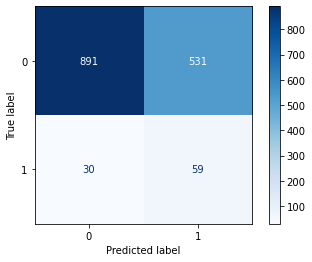

In [29]:
# View confusion matrix

plot_confusion_matrix(nb, Xs_test, y_test, cmap='Blues', values_format='d');

Using Naive Bayes, out of 1511 data points in our test dataset, we classified 950 (62.87%) correctly. 

### 2.3 Random Forest

In [30]:
%%time

print(f'Fitting Random Forest Classifier')   

# Set up pipeline
rf_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ])

# Hyperparameters
rf_params = {
    'rf__n_estimators': [80, 100, 120],
    'rf__max_depth': [3, 5],
    'rf__min_samples_leaf': [2, 4],
    'rf__min_samples_split' : [2, 4]
}

# Instantiate 5-fold GridSearchCV.
gs_rf = GridSearchCV(rf_pipe, param_grid = rf_params, cv=5,
                     scoring='roc_auc')

# Fit
gs_rf.fit(Xs_train, y_train)
gs_rf_model = gs_rf.best_estimator_

# See results
print(f'The best parameters are {gs_rf.best_estimator_}.')

Fitting Random Forest Classifier
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        n_estimators=120, random_state=42))]).
CPU times: user 2min 33s, sys: 37.8 s, total: 3min 11s
Wall time: 49.3 s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [31]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                       random_state=42)
rf.fit(Xsm_train, ysm_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                       random_state=42)

In [32]:
# Append to the lists
model_name.append('Random Forest')
model_scores.append(rf.score(Xsm_train, ysm_train))
model_var.append(rf)
model_test_scores.append(rf.score(Xs_test,y_test)) 

### Evaluating Random Forest Results

In [33]:
imp_rf = pd.DataFrame(rf.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights',ascending=False)

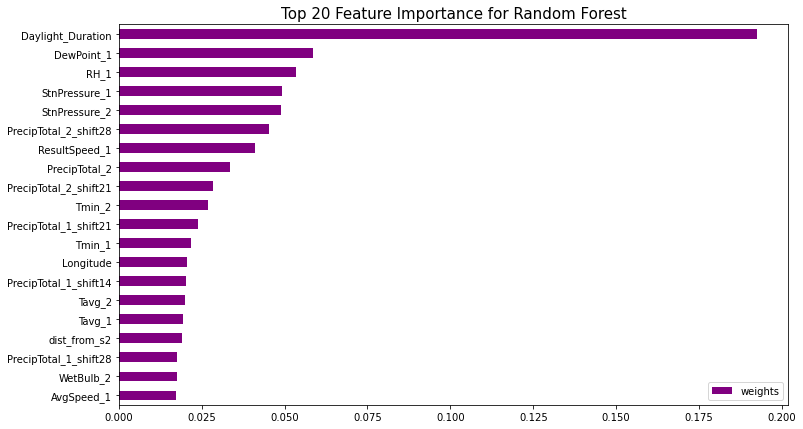

In [34]:
# Plotting Top 20 features in bar chart
imp_rf.head(20).plot(kind='barh', label=imp_rf.columns[:20], figsize=(12,7), color='purple')
plt.title('Top 20 Feature Importance for Random Forest', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

As earlier seen when evaluating the Logistic Regression results, mosquitos activity is influenced by daylight duraton and will look to avoid sunlight.

The next top 2 features are Dewpoint and Relative Humidity. These are inter-related, as the dew point is the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100%.
According to this [article](https://www.orkin.com/pests/mosquitoes/when-are-mosquitoes-most-active), Relative humidity is important to mosquito activity. In general, high humidity conditions favor mosquito activity

Also interesting is that Station StnPressure_1 and StnPressure_2 are one of the more important features. According to this [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3788776/), there is some evidence that insects adjust their behaviours associated with flight, mating and foraging in response to changes in barometric pressure, which would in turn affect the Wnv Presence. 

In [35]:
# Get predictions
preds = rf.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/joeltan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


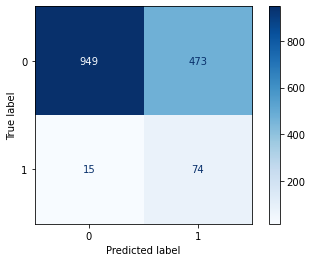

In [36]:
# View confusion matrix

plot_confusion_matrix(rf, Xs_test, y_test, cmap='Blues', values_format='d');

Using Random Forest, out of 1511 data points in our test dataset, we classified 1023 (67.70%) correctly. 

### 2.4 ExtraTrees

In [37]:
%%time

print(f'Fitting Extra Trees')      

# Set up pipeline
et_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('et', ExtraTreesClassifier(random_state=42))
    ])

# Hyperparameters
et_params = {
    'et__n_estimators': [80, 100, 120],
    'et__max_depth': [3, 5],
    'et__min_samples_leaf': [2, 4],
    'et__min_samples_split' : [2, 4]
}

# Instantiate 5-fold GridSearchCV.
gs_et = GridSearchCV(et_pipe, param_grid = et_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit
gs_et.fit(Xs_train, y_train)
gs_et_model = gs_et.best_estimator_

# See results
print(f'The best parameters are {gs_et.best_estimator_}.')

Fitting Extra Trees
Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('et',
                 ExtraTreesClassifier(max_depth=5, min_samples_leaf=4,
                                      n_estimators=120, random_state=42))]).
CPU times: user 1.76 s, sys: 396 ms, total: 2.16 s
Wall time: 6.75 s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [38]:
et = ExtraTreesClassifier(max_depth=5, min_samples_leaf=4,n_estimators=120,
                     random_state=42)
et.fit(Xsm_train, ysm_train)

ExtraTreesClassifier(max_depth=5, min_samples_leaf=4, n_estimators=120,
                     random_state=42)

In [39]:
# Append to the lists
model_name.append('ExtraTrees')
model_scores.append(et.score(Xsm_train, ysm_train))
model_var.append(et)
model_test_scores.append(et.score(Xs_test,y_test))

### Evaluating ExtraTrees Results

In [40]:
imp_et = pd.DataFrame(et.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

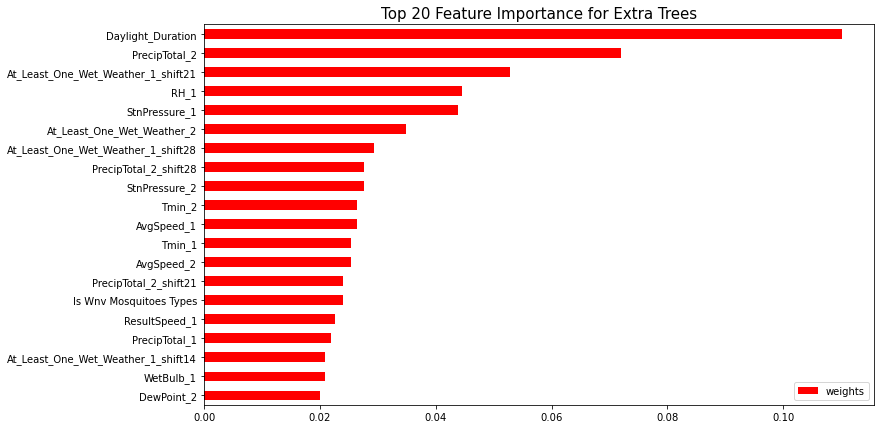

In [41]:
# Top 20 features
imp_et.head(20).plot(kind='barh', label=imp_et.columns, figsize=(12,7), color='red')
plt.title('Top 20 Feature Importance for Extra Trees', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

For this model, Daylight Duration is the strongest predictor. 

Out of the next 6 top important features, 4 of them are related to precipitation and wet weather. This makes sense as stagnant water is ideal for mosquito breeding. 

In [42]:
# Get predictions
preds = et.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/joeltan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


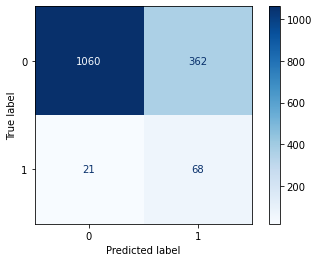

In [43]:
# View confusion matrix

plot_confusion_matrix(et, Xs_test, y_test, cmap='Blues', values_format='d');

Using ExtraTrees, out of 1511 data points in our test dataset, we classified 1128 (74.65%) correctly. 

### 2.5 AdaBoost

In [44]:
%%time

print(f'Fitting AdaBoost')     

# Set up pipeline
ada_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('ada', AdaBoostClassifier(random_state=42))
    ])

# Hyperparameters
ada_params = {
    'ada__n_estimators': [20, 30, 40, 50],
    'ada__learning_rate': [0.8, 0.9, 1]
}

# Instantiate 5-fold GridSearchCV.
gs_ada = GridSearchCV(ada_pipe, param_grid = ada_params, cv=5,
                      scoring='roc_auc', n_jobs=-1,
                     verbose=1)

# Fit
gs_ada.fit(Xs_train, y_train)
gs_ada_model = gs_ada.best_estimator_

# See results
print(f'The best parameters are {gs_ada.best_estimator_}.')

Fitting AdaBoost
Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.8, n_estimators=30,
                                    random_state=42))]).
CPU times: user 1.51 s, sys: 342 ms, total: 1.85 s
Wall time: 5.6 s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [45]:
ada = AdaBoostClassifier(learning_rate=0.8, n_estimators=30, random_state=42)
ada.fit(Xsm_train, ysm_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=30, random_state=42)

In [46]:
# Append to the lists
model_name.append('AdaBoost')
model_scores.append(ada.score(Xsm_train, ysm_train))
model_var.append(ada)
model_test_scores.append(ada.score(Xs_test,y_test))

### Evaluating AdaBoost Results

In [47]:
imp_ada = pd.DataFrame(ada.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

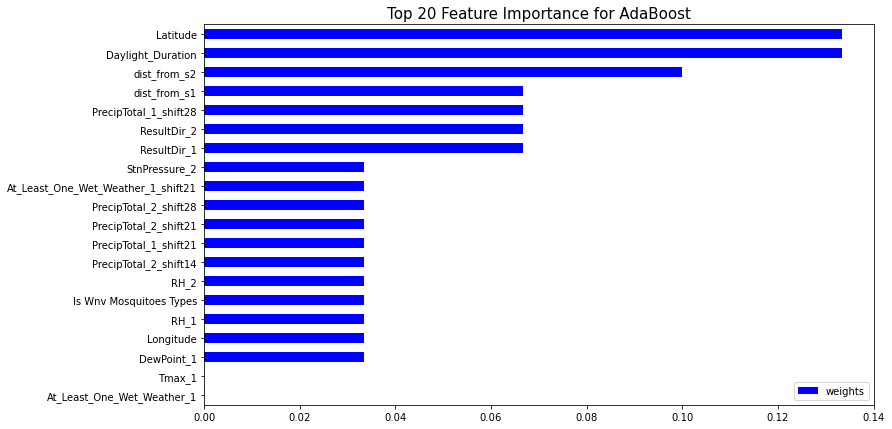

In [48]:
# Plot in bar chart
imp_ada.head(20).plot(kind='barh', label=imp_ada.columns[:20], figsize=(12,7), color='blue')
plt.title('Top 20 Feature Importance for AdaBoost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

For this model, out of the top 4 features, 1 is daylight duration which we had also seen in the previous models. The other 3, however are 'Latitude', 'dist_from_s2' and 'dist_from_s1', which desribes the location and the distance from Station 1 and Station 2 and are not part of the top features seen in previous models.

Though this might seem uncanny at first, the distance from Station 1 and Station 2 would indicate how much influence the weather affects the location since the weather conditions are measured at the Stations. Thus, the nearer the data point is to the Station, the more influence the weather would have had, which would in turn affects the prsence of the Wnv virus.



In [49]:
# Get predictions
preds = ada.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/joeltan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


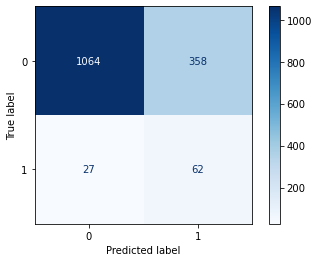

In [50]:
# View confusion matrix

plot_confusion_matrix(ada, Xs_test, y_test, cmap='Blues', values_format='d');

Using AdaBoost, out of 1511 data points in our test dataset, we classified 1126 (74.52%) correctly. 

### 2.6 GradientBoost

In [51]:
%%time

print(f'Fitting Gradient Boost')     

# Set up pipeline
gboost_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('gboost', GradientBoostingClassifier())
    ])

# Hyperparameters
gboost_params = {
    'gboost__n_estimators': [80, 100, 120, 150],
    'gboost__max_depth': [1, 2, 3],
    'gboost__min_samples_split': [2, 4],
    'gboost__min_samples_leaf': [1, 2]
}

# Instantiate 5-fold GridSearchCV.
gs_gboost = GridSearchCV(gboost_pipe, param_grid = gboost_params, cv=5,
                         scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit
gs_gboost.fit(Xs_train, y_train)
gs_gboost_model = gs_ada.best_estimator_

# See results
print(f'The best parameters are {gs_gboost.best_estimator_}.')

Fitting Gradient Boost
Fitting 5 folds for each of 48 candidates, totalling 240 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('gboost',
                 GradientBoostingClassifier(max_depth=2, min_samples_leaf=2))]).
CPU times: user 3.73 s, sys: 435 ms, total: 4.16 s
Wall time: 1min 37s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [52]:
gboost = GradientBoostingClassifier(max_depth=2, min_samples_leaf=2)
gboost.fit(Xsm_train, ysm_train)

GradientBoostingClassifier(max_depth=2, min_samples_leaf=2)

In [53]:
# Append to the lists
model_name.append('GradientBooast')
model_scores.append(gboost.score(Xsm_train, ysm_train))
model_var.append(gboost)
model_test_scores.append(gboost.score(Xs_test,y_test)) 

In [54]:
imp_gboost = pd.DataFrame(gboost.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

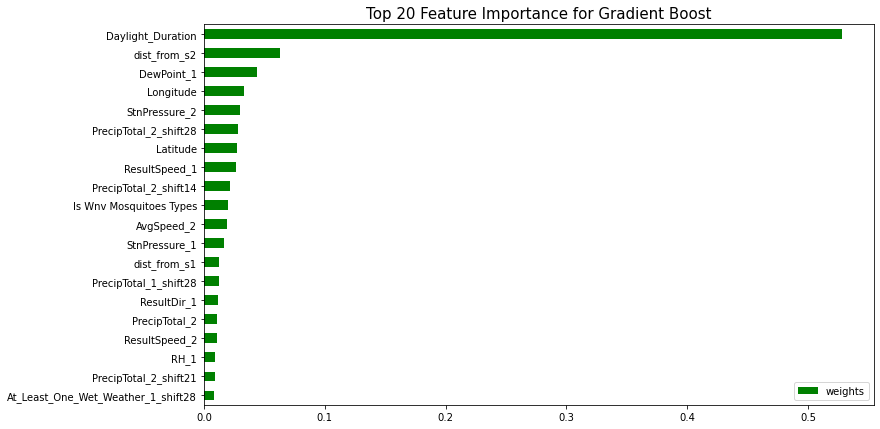

In [55]:
# Plot in bar chart
imp_gboost.head(20).plot(kind='barh', label=imp_gboost.columns[:20], figsize=(12,7), color='green')
plt.title('Top 20 Feature Importance for Gradient Boost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

For this model, unlike the results seen in the previous models, the top features contain a mix of weather conditions and location and distance from Station 1 and Station 2. 

In [56]:
# Get predictions
preds = gboost.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/joeltan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


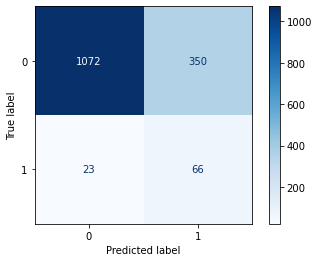

In [57]:
# View confusion matrix

plot_confusion_matrix(gboost, Xs_test, y_test, cmap='Blues', values_format='d');

Using GradientBoost, out of 1511 data points in our test dataset, we classified 1138 (75.31%) correctly. 

## <a name="sec_3"></a>Section 3: Final Model Selection

In [58]:
# View the evaluation metrics for all models in a dataframe

precision_list = []
recall_list = []
fscore_list = []
auc_list_train = []
auc_list_test = []
for model in model_var:
    y_pred = model.predict(Xs_test)
    y_pred_train = model.predict(Xs_train)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)
    auc_list_train.append(roc_auc_score(y_train, y_pred_train))
    auc_list_test.append(roc_auc_score(y_test, y_pred))

table_of_results = pd.DataFrame({'Model Type': model_name,
              'Train AUC': auc_list_train,
              'Test AUC': auc_list_test,
              'F1-Score': fscore_list,
             'Recall': recall_list,
              'Precision': precision_list,
              'Train Accuracy': model_scores,
             'Test Accuracy': model_test_scores})
table_of_results['Overfitting'] = table_of_results['Train Accuracy'] - table_of_results['Test Accuracy']
table_of_results

,Model Type,Train AUC,Test AUC,F1-Score,Recall,Precision,Train Accuracy,Test Accuracy,Overfitting
0,Logistic Regression,0.791011,0.752979,0.552109,0.752979,0.568403,0.804115,0.743216,0.060898
1,Naive Bayes,0.654022,0.644752,0.467174,0.644752,0.533713,0.657289,0.628723,0.028566
2,Random Forest,0.773268,0.749415,0.514089,0.749415,0.559862,0.804554,0.677035,0.127519
3,ExtraTrees,0.776749,0.754737,0.554513,0.754737,0.569357,0.792597,0.746525,0.046072
4,AdaBoost,0.779383,0.722436,0.545206,0.722436,0.561436,0.813610,0.745202,0.068408
5,GradientBooast,0.796718,0.747720,0.556597,0.747720,0.568825,0.828732,0.753144,0.075589


As earlier stated, we will first use AUC to filter out what model is best for this classficiation problem. This is because AUC works much better for imbalanced dataset.

Now, from the 'AUC' scores, it is clear that Naive Bayes is the worst performing models with scores of ~0.65 and ~0.78 respectively. 

Naive Bayes is a classification method based on Bayes' theorem that derives the probability of the given vector being assocaited with a label. it has a naive assumption of conditional independece for every feature, which means that the algorithm expects the features to be independent which is not always the case. Thus, if some of the feautes are in fact dependent on each other, the prediction might be poor. In this classification problem, many of the features are in fact related to each other as several of them are weather related. So, Naive Bayes is not the optimal model for this case and we can eliminate it from our choice.

Next, let us look at Random Forest and ExtraTrees, which have the next 2 better AUC Scores.

Random Forest consists of a large number of individual decision trees that operate as an ensemble. Each invidual trees in the random forest spits out a class prediction and the class with the most votes become our model's prediction.
Random Forest performs best when there is low correlation between the models, whereby uncorrelated models can produce ensemble predictions that are more accurate than any of the individual predictions. The reason for this wonderful effect is that the trees protect each other from their individual errors. 

Exratrees is an extension of Random Forests, and like Random Forests, are trained using the random subspace method (sampling of features). However, they are trained using the random subspace method (sampling of features). This reduces the variance, but causes an increase in bias. This is reflected in the Train and Test Scores, where ExtraTrees scored slightly better in the Test Scores but slightly worse in the Train Scores compared to Random Forest.

Why then, are Random Forest and ExtraTrees one of the worst performing models for this problem? This could be because, for the model to do well, the predictions and errors made by the individual trees need to have low correlations with each other, and many of our features are weather related and are thus have decent coorelations with one another.

Now then, we are left with Logistic Regression, AdaBoost and Gradient boost

Logistic regression is a linear classification method that learns the probability of a sample belonging to a certain class. Logistic regression tries to find the optimal decision boundary that best separates the classes. Logistic Regression is a discriminative model, whereby for Feature X and Target y, it directly models the posterior probability of P(y|X) by learning the input to output mapping by minimising the error. Logistic regression splits feature space linearly, and typically works reasonably well even when some of the variables are correlated. A major limitation, however, is the assumption of linearity between the dependent variable and the independent variables.

AdaBoost is an ensemble learning method, which uses an iterative approach to learn fromn the mistakes of weak classifiers, and turn them into strong ones. Thus, the core principle of AdaBoost is to fit a sequence of weak on repeatedly modified versions of the data. After each fit, the importance weights on each observation need to be updated. As a result, AdaBoost can be used to improve the accuracy of the weak classifiers and hence makes it flexible. However, a drawback is that it is also extremely sensitive to noisy data and outliers.

GradientBoost is also a Boosting ensemlbe model and is a generalization of boosting to arbitrary, differentiable loss functions. It is a robust machine learning algorithm made up of Gradient Descent and Boosting. In the case of AdaBoost, it minimises the exponential loss function that can make the algorithm sensitive to the outliers. With Gradient Boosting, any differentiable loss function can be utilised. Gradient Boosting algorithm is more robust to outliers than AdaBoost. Another benefit is its natural handling of mixed data types (= heterogeneous features).

Now that we have a greater appreciation of what these models do, let us compare their scores.

Out of Logsitic Regression, AdaBoost and GradientBoost, GradientBoost and Logistic Regression Recall Scores are similar and are slightly better than AdaBooast. Recall talks about how, out of all the labeled Postives by the model, how many of them are actually Postive. Thus, this is a good measure to use when the costs of False Negative is high. This is relevant in this situation, as, we feel that minimising the False Negatives is very important. This is because we feel that it is unethical to tell the public that a certain lcation do not have any presence of the Wnv Virus when in fact there is. We thus eliminate AdaBoost from our final model selection.

Between Logistic Regression and GradientBoost, though there is a slight greater overfitting for GradientBoost compared to Logistic Regression, GradientBoost scored slightly higher on the Train and Test Scores. Also, we feel more confident of the fact that GradientBoost, in general, has a high predictive power.

As a result, we choose GradientBoost as our final model selection.

In [59]:
# Assign the selected production model
production_model = gboost

In [60]:
# Save scaler as a pickle file
outfile = open('scaler_model.pkl','wb')
pickle.dump(ss, outfile)
outfile.close()

In [61]:
# Save model as a pickle file
outfile = open('production_model.pkl','wb')
pickle.dump(production_model, outfile)
outfile.close()

## <a name="sec_4"></a>Section 4: Cleaning & Preprocessing for Test dataset

We have already cleaned and performed feature engineering on the test dataset in the previous sections. For the column "Species", though, there is a variable that is not found in the train dataset. This varaible is called "UNSPECIFIED CULEX". We would need to feature engineering on this. 

In [62]:
# Functions to clean the test dataset

def create_date_predictors(data, date_col_name):
    data['Year'] = data[date_col_name].dt.year
    data['Month'] = data[date_col_name].dt.month
    data['Week'] = data[date_col_name].dt.isocalendar().week
    data['Year-Month'] = data['Year'].astype('str') + "-" + data['Month'].astype('str')
    data['Year-Week'] = data['Year'].astype('str') + "-" + data['Week'].astype('str')    
    return data

def transform_weather_to_weekly(weather):
    # Set all data types correctly
    weather['Date'] = pd.to_datetime(weather['Date'])
    weather['Sunrise_1'] = pd.to_datetime(weather['Sunrise_1'])
    weather['Sunset_1'] = pd.to_datetime(weather['Sunset_1'])

    # Create date related predictors
    weather = create_date_predictors(weather, 'Date')

    # Since mosquitoes dies/greatly inhibited at temperature below 50F, to create 4 additional predictors to indicate this for Tavg and Tmin
    weather['Tavg_1_Below_50F'] = weather['Tavg_1'].apply(lambda x: 1 if x < 50 else 0)
    weather['Tmin_1_Below_50F'] = weather['Tmin_1'].apply(lambda x: 1 if x < 50 else 0)
    weather['Tavg_2_Below_50F'] = weather['Tavg_2'].apply(lambda x: 1 if x < 50 else 0)
    weather['Tmin_2_Below_50F'] = weather['Tmin_2'].apply(lambda x: 1 if x < 50 else 0)

    # Calculate duration of daylight
    weather['Daylight_Duration'] = (weather['Sunset_1'] - weather['Sunrise_1']).dt.total_seconds()/60

    # Calculate relative humidity
    weather['RH_1'] = mpcalc.relative_humidity_from_dewpoint(weather['Tavg_1'].values * units.degF, weather['DewPoint_1'].values * units.degF)
    weather['RH_2'] = mpcalc.relative_humidity_from_dewpoint(weather['Tavg_2'].values * units.degF, weather['DewPoint_2'].values * units.degF)

    # Define wet weather
    wet_weather = ['GR', 'TS', 'RA', 'DZ', 'GS', 'UP', 'SQ', 'SH', 'PY', 'SN', 'SG', 'PL', 'IC']

    # Check if the day is a wet weather
    weather['Wet_Weather_1'] = weather['CodeSum_1'].apply(lambda x: int(any([1 if weather in x else 0 for weather in wet_weather])))
    weather['Wet_Weather_2'] = weather['CodeSum_2'].apply(lambda x: int(any([1 if weather in x else 0 for weather in wet_weather])))

    # Set Date as index
    weather.set_index('Date', inplace=True)

    # Shift Wet_Weather and PrecipTotal by 7 days
    lag = 7
    weather['Wet_Weather_1_shift7'] = weather['Wet_Weather_1'].shift(lag)
    weather['Wet_Weather_2_shift7'] = weather['Wet_Weather_2'].shift(lag)
    weather['PrecipTotal_1_shift7'] = weather['PrecipTotal_1'].shift(lag)
    weather['PrecipTotal_2_shift7'] = weather['PrecipTotal_2'].shift(lag)

    # Shift Wet_Weather and PrecipTotal by 14 days
    lag = 14
    weather['Wet_Weather_1_shift14'] = weather['Wet_Weather_1'].shift(lag)
    weather['Wet_Weather_2_shift14'] = weather['Wet_Weather_2'].shift(lag)
    weather['PrecipTotal_1_shift14'] = weather['PrecipTotal_1'].shift(lag)
    weather['PrecipTotal_2_shift14'] = weather['PrecipTotal_2'].shift(lag)

    # Shift Wet_Weather and PrecipTotal by 21 days
    lag = 21
    weather['Wet_Weather_1_shift21'] = weather['Wet_Weather_1'].shift(lag)
    weather['Wet_Weather_2_shift21'] = weather['Wet_Weather_2'].shift(lag)
    weather['PrecipTotal_1_shift21'] = weather['PrecipTotal_1'].shift(lag)
    weather['PrecipTotal_2_shift21'] = weather['PrecipTotal_2'].shift(lag)

    # Shift Wet_Weather and PrecipTotal by 28 days
    lag = 28
    weather['Wet_Weather_1_shift28'] = weather['Wet_Weather_1'].shift(lag)
    weather['Wet_Weather_2_shift28'] = weather['Wet_Weather_2'].shift(lag)
    weather['PrecipTotal_1_shift28'] = weather['PrecipTotal_1'].shift(lag)
    weather['PrecipTotal_2_shift28'] = weather['PrecipTotal_2'].shift(lag)

    #create dataframe for weekly, monthly and yearly
    weather_weekly = weather.resample('W').mean()
    return pd.DataFrame(weather_weekly)

def transform_test_weather_weekly(data, weather_weekly):
    """
    This function helps to transform the test data into weekly data and merge with the weather_weekly dataset.
    Additonal features are feature engineered to be used for modeling.
    """
    # Drop columns not in the list of column names
    data.drop(columns=[col for col in data.columns if col not in ['Id', 'Date', 'Species', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']], inplace=True)
    
    # Convert Date to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Create date additional date features
    data = create_date_predictors(data, 'Date')
    
    # Set Date as index
    data.set_index('Date', inplace=True)
    
    # Get Weekly Date by resampling and replace date in data through merging
    # Get Weekly Date by resampling
    temp = data['AddressAccuracy'].resample('W').mean()
    temp = pd.DataFrame(temp)
    temp['Year-Week'] = temp.index.year.astype('str') + "-" + temp.index.isocalendar().week.astype('str')
    temp.drop(columns=['AddressAccuracy'], inplace=True)
    temp.reset_index(inplace=True)
    weekly_date_df = temp.drop_duplicates()
    
    # Replace date in data through merging
    data_weekly = pd.merge(left=data,
                    right=weekly_date_df,
                    on='Year-Week',
                    how='left', )
    data_weekly.set_index('Date', inplace=True)
    
   # Merge test
    data_weather_weekly = pd.merge(left=data_weekly,
                                    right=weather_weekly,
                                    left_index=True,
                                    right_index=True,
                                    how='left'
                                   )

    # Drop unneeded columns
    data_weather_weekly.drop(columns=['Year_y', 'Month_y', 'Week_y'], inplace=True)
    data_weather_weekly.rename(columns={'Year_x': 'Year', 'Month_x': 'Month', 'Week_x': 'Week'}, inplace=True)

    # Check if there are any null rows after merge
    print(f"There are {data_weather_weekly.isnull().sum().sum()} rows with N.A.")

    #Check that there are no duplicates
    print(f"There are {data_weather_weekly.shape[0] - data_weather_weekly.drop_duplicates().shape[0]} duplicated rows.")

    # Creating new predictors if wet weather or temperature fell below 50F at least once per week
    data_weather_weekly['At_Least_One_Wet_Weather_1'] = data_weather_weekly['Wet_Weather_1'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Wet_Weather_2'] = data_weather_weekly['Wet_Weather_2'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Wet_Weather_1_shift7'] = data_weather_weekly['Wet_Weather_1_shift7'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Wet_Weather_2_shift7'] = data_weather_weekly['Wet_Weather_2_shift7'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Wet_Weather_1_shift14'] = data_weather_weekly['Wet_Weather_1_shift14'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Wet_Weather_2_shift14'] = data_weather_weekly['Wet_Weather_2_shift14'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Wet_Weather_1_shift21'] = data_weather_weekly['Wet_Weather_1_shift21'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Wet_Weather_2_shift21'] = data_weather_weekly['Wet_Weather_2_shift21'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Wet_Weather_1_shift28'] = data_weather_weekly['Wet_Weather_1_shift28'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Wet_Weather_2_shift28'] = data_weather_weekly['Wet_Weather_2_shift28'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Tavg_1_Below_50F'] = data_weather_weekly['Tavg_1_Below_50F'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Tmin_1_Below_50F'] = data_weather_weekly['Tmin_1_Below_50F'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Tavg_2_Below_50F'] = data_weather_weekly['Tavg_2_Below_50F'].apply(lambda x: 1 if x > 0 else 0)
    data_weather_weekly['At_Least_One_Tmin_2_Below_50F'] = data_weather_weekly['Tmin_2_Below_50F'].apply(lambda x: 1 if x > 0 else 0)

    # Create distance of trap from weather stations
    traps = np.array(list(zip(data_weather_weekly['Latitude'].values, data_weather_weekly['Longitude'].values)))
    station1 = np.array([41.786, -87.752])
    station2 = np.array([41.995, -87.933])
    data_weather_weekly['dist_from_s1'] = [np.linalg.norm(i-station1) for i in traps]
    data_weather_weekly['dist_from_s2'] = [np.linalg.norm(i-station2) for i in traps]

    # Drop unneeded columns
    drop_columns = ['Tavg_1_Below_50F',
                    'Tmin_1_Below_50F',
                    'Tavg_2_Below_50F',
                    'Tmin_2_Below_50F',
                    'Wet_Weather_1',
                    'Wet_Weather_2',
                    'Wet_Weather_1_shift7',
                    'Wet_Weather_2_shift7',
                    'Wet_Weather_1_shift14',
                    'Wet_Weather_2_shift14',
                    'Wet_Weather_1_shift21',
                    'Wet_Weather_2_shift21',
                    'Wet_Weather_1_shift28',
                    'Wet_Weather_2_shift28',]
    data_weather_weekly.drop(columns=drop_columns, inplace=True)

    # Convert to object
    convert_to_object=['At_Least_One_Wet_Weather_1',
                       'At_Least_One_Wet_Weather_2',
                       'At_Least_One_Wet_Weather_1_shift7',
                       'At_Least_One_Wet_Weather_2_shift7',
                       'At_Least_One_Wet_Weather_1_shift14',
                       'At_Least_One_Wet_Weather_2_shift14',
                       'At_Least_One_Wet_Weather_1_shift21',
                       'At_Least_One_Wet_Weather_2_shift21',
                       'At_Least_One_Wet_Weather_1_shift28',
                       'At_Least_One_Wet_Weather_2_shift28',
                       'At_Least_One_Tavg_1_Below_50F',
                       'At_Least_One_Tmin_1_Below_50F',
                       'At_Least_One_Tavg_2_Below_50F',
                       'At_Least_One_Tmin_2_Below_50F']
    data_weather_weekly[convert_to_object] = data_weather_weekly[convert_to_object].astype('str')
    
    # Return dataframe
    return data_weather_weekly

In [69]:
# Load weather and test data
weather = pd.read_csv('../assets/cleaned_datasets/weather_clean.csv')
test = pd.read_csv('../assets/raw_datasets/test.csv')

# Clean and process the data
weather_weekly = transform_weather_to_weekly(weather)
test_weather_weekly = transform_test_weather_weekly(test, weather_weekly)

There are 0 rows with N.A.
There are 0 duplicated rows.


In [70]:
# For species, there is a variable that is not found in the train dataset. This variable is called 'UNSPECIFIED CULEX'
test_weather_weekly['Species'].value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
UNSPECIFIED CULEX         14345
CULEX ERRATICUS           14345
Name: Species, dtype: int64

In [71]:
# Breeds of mosquitoes that carries West Nile Virus
wnv_species = ['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS']

In [72]:
# If Mosquitoes is of the 3 types, Is Wnv Mosquitoes Types is 1
test_weather_weekly['Is Wnv Mosquitoes Types'] = test_weather_weekly['Species'].apply(lambda x: 1 if x in wnv_species else 0)

In [73]:
# Drop additional columns
test_weather_weekly.drop(['Id','Species','AddressAccuracy','Year','Month','Week','Year-Month','Year-Week'],
                        axis=1, inplace=True)

In [74]:
# Save the cleaned_dataset
test_weather_weekly.to_csv('../assets/cleaned_datasets/test_weather_weekly.csv',index=False)

## <a name="sec_5"></a>Section 5: Kaggle Submission

In [75]:
# Load in production model and scaler
ss = pickle.load(open('scaler_model.pkl', 'rb'))
model = pickle.load(open('production_model.pkl', 'rb'))

print(ss)
print(model)

StandardScaler()
GradientBoostingClassifier(max_depth=2, min_samples_leaf=2)


In [76]:
# Scale Processed Test Data
Xscaled_test = ss.transform(test_weather_weekly)

/Users/joeltan/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [77]:
# Get Predictions
predictions = model.predict(Xscaled_test)

In [78]:
# Import original Test Data
original_test = pd.read_csv('../assets/raw_datasets/test.csv')

In [79]:
submission = pd.DataFrame(original_test['Id'])
submission['WnvPresent'] = predictions

In [80]:
submission['WnvPresent'].value_counts()

0    114921
1      1372
Name: WnvPresent, dtype: int64

In [81]:
# Save csv
submission.to_csv('../assets/Kaggle/submission_predictions.csv', index=False)

![Submission](../assets/Kaggle/kaggle_submission.png)

## <a name="sec_6"></a>Section 6: Future Recommendations

As ealier mentioned, we dropped the 'NumMosquitos' column as one of the features of our model as we were unable to create a good enough linear regression model to predict the 'NumMosquitos' in our test dataset. Moving forward, we can try to create a clasification model instead of a Regression model, since 'NumMosquitos' will always be an integer value. So, Class 1 = 1 Mosquito, Class 2 = 2 Mosquitos, Class 3 = 3 Mosquitos etc. If our results are good, we can then look to inclide 'NumMosquios' as one of the features of our final selected model.

Furthermore, we can also look to include how densely populated each of the location is as part of our features. This is because, it could be that areas with a more dense human population would experience a higher number of mosquitos in the area since mosquitoes feed off the blood of humans. This would increase the probability of the Wnv virus too since there are more humans to transmit the virus to.

Additionally, the features/layouts of the location might be a significant factor too. Presence of forest areas, water sources, type of buildings are some examples that might affect the breeding of mosquitos, so we can look to include these features in the future to further improve our model.